1. Load all the necessary functions

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import requests
import torch.nn as nn
import torch.optim as optim
import random
!pip install datasets


2. import CNN/Daily Mail dataset, from https://huggingface.co/datasets/cnn_dailymail

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_dataset
import nltk
nltk.download('punkt')


# smaller dataset
dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:500]")  # Load only 500 examples for training

# Train, validation, and test splits
train_data = dataset
val_data = load_dataset('cnn_dailymail', '3.0.0', split="validation[:100]")  # Load 100 examples for validation
test_data = load_dataset('cnn_dailymail', '3.0.0', split="test[:100]")  # Load 100 examples for testing

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]
    return tokenized_sentences

# summaries
train_summaries = [preprocess_text(example['highlights']) for example in train_data]
train_texts = [preprocess_text(example['article']) for example in train_data]

val_summaries = [preprocess_text(example['highlights']) for example in val_data]
val_texts = [preprocess_text(example['article']) for example in val_data]

test_summaries = [preprocess_text(example['highlights']) for example in test_data]
test_texts = [preprocess_text(example['article']) for example in test_data]


# number of examples in each split
print("Data Dimensions:")
print("Train data examples:", len(train_data))
print("Validation data examples:", len(val_data))
print("Test data examples:", len(test_data))

#  dimensions of target summaries and texts
print("\nTarget Summaries Dimensions:")
print("Train summaries:", len(train_summaries))
print("Validation summaries:", len(val_summaries))
print("Test summaries:", len(test_summaries))

print("\nTexts (Articles) Dimensions:")
print("Train texts:", len(train_texts))
print("Validation texts:", len(val_texts))
print("Test texts:", len(test_texts))


In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import torch.nn.utils.rnn as rnn_utils
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# maximum length for each sentence
max_length = 512
max_summary_length = 100



# Check for non-string elements in train_texts
vocab_input = {'<OOV>': 0, '<sos>': 1}
word_counter_input = Counter(word for text_list in train_texts for text in text_list for word in text)
for word, count in word_counter_input.items():
    if word not in vocab_input:
        vocab_input[word] = len(vocab_input)

vocab_target = {'<OOV>': 0, '<sos>': 1}
word_counter_target = Counter(word for summary_list in train_summaries for summary in summary_list for word in summary)
for word, count in word_counter_target.items():
    if word not in vocab_target:
        vocab_target[word] = len(vocab_target)

def sentences_to_sequence_input(sentences, max_length):
    flattened = [word for sentence in sentences for word in sentence]
    return [vocab_input.get(word, vocab_input['<OOV>']) for word in flattened[:max_length]]

def sentences_to_sequence_target(sentences, max_length):
    flattened = [word for sentence in sentences for word in sentence]
    return [vocab_target.get(word, vocab_target['<OOV>']) for word in flattened[:max_length]]


train_sequences_input = [sentences_to_sequence_input(text, max_length) for text in train_texts]
val_sequences_input = [sentences_to_sequence_input(text, max_length) for text in val_texts]
test_sequences_input = [sentences_to_sequence_input(text, max_length) for text in test_texts]

train_sequences_target = [sentences_to_sequence_target(summary, max_summary_length) for summary in train_summaries]
val_sequences_target = [sentences_to_sequence_target(summary, max_summary_length) for summary in val_summaries]
test_sequences_target = [sentences_to_sequence_target(summary, max_summary_length) for summary in test_summaries]

class CustomDataset(Dataset):
    def __init__(self, sequences_input, sequences_target, max_length):
        self.sequences_input = sequences_input
        self.sequences_target = sequences_target
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, index):
        input_sequence = self.sequences_input[index]
        target_summary = self.sequences_target[index]
        input_sequence = self.pad_sequence(input_sequence, self.max_length)
        target_summary = self.pad_sequence(target_summary, self.max_length)  # Changed to max_length
        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_summary, dtype=torch.long)
        return input_tensor, target_tensor

    def pad_sequence(self, sequence, max_length):
        if len(sequence) < max_length:
            sequence = sequence + [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        return sequence


train_dataset = CustomDataset(train_sequences_input, train_sequences_target, max_length)
val_dataset = CustomDataset(val_sequences_input, val_sequences_target, max_length)
test_dataset = CustomDataset(test_sequences_input, test_sequences_target, max_length)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch_inputs, batch_targets in train_loader:
    break

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0, :]
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1.detach()
        return outputs

    def generate_summary(self, src, max_len=100):
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = torch.tensor([vocab_input['<sos>']]*batch_size).to(device)
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            top1 = output.argmax(1)
            input = top1
        return outputs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_input_dim = len(vocab_input)
decoder_output_dim = len(vocab_target)
embedding_dim = 100
hidden_dim = 256
num_layers = 2
dropout = 0.5

encoder = Encoder(encoder_input_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)
decoder = Decoder(decoder_output_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training Epochs:  20%|██        | 4/20 [21:08<1:23:57, 314.84s/it]


Epoch 5/20
Training Loss: 0.9269 - Training Accuracy: 0.9334
Validation Loss: 0.5681 - Validation Accuracy: 0.9452


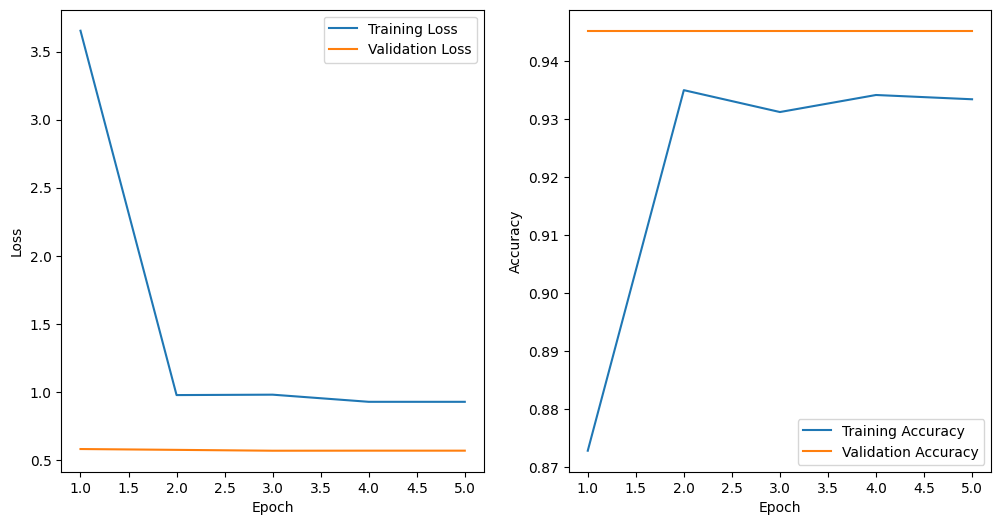

Training Epochs:  45%|████▌     | 9/20 [43:35<49:02, 267.51s/it]


Epoch 10/20
Training Loss: 0.8815 - Training Accuracy: 0.9324
Validation Loss: 0.5367 - Validation Accuracy: 0.9452


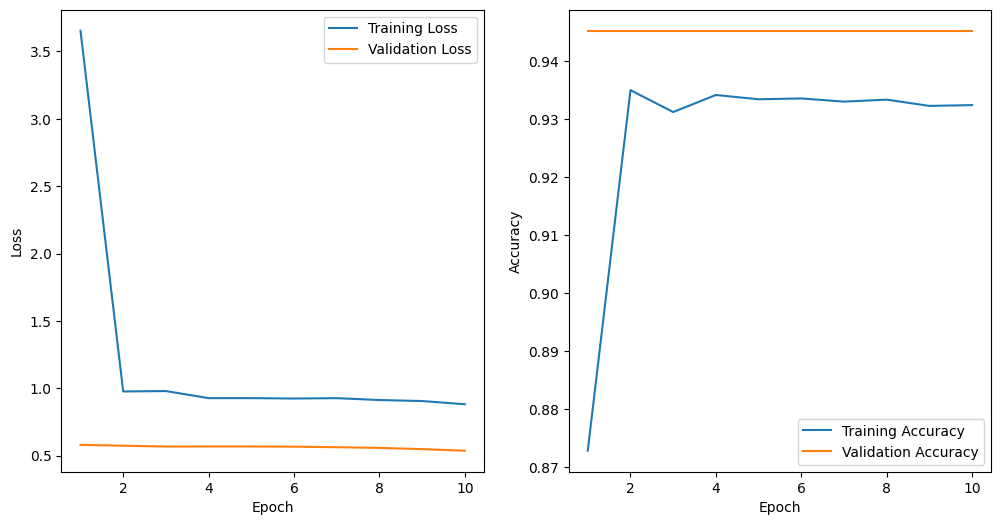

Training Epochs:  70%|███████   | 14/20 [1:06:02<27:08, 271.46s/it]

In [ ]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch



# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# calculate accuracy
def calculate_accuracy(preds, targets):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == targets).sum().item()
    return correct / len(targets)

# calculate loss
def calculate_loss(preds, targets):
    loss = criterion(preds, targets)
    return loss.item()

def train(model, num_epochs, train_loader, val_loader, print_every=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(1, num_epochs + 1), desc='Training Epochs'):
        # training
        model.train()
        running_train_loss = 0.0
        correct_train = 0

        for batch_inputs, batch_targets in train_loader:
            for batch_inputs, batch_targets in train_loader:
                  break

            start_token = torch.zeros((batch_targets.size(0), 1), dtype=batch_targets.dtype).to(device)
            decoder_input = torch.cat((start_token, batch_targets[:, :-1]), dim=1).to(device)

            decoder_target = batch_targets[:, 1:].to(device)

            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs, decoder_input)
            outputs = outputs[:, :-1, :]
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), decoder_target.reshape(-1))

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            correct_train += (outputs.argmax(2) == decoder_target).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct_train / (len(train_loader.dataset) * decoder_target.shape[1])
        train_accuracies.append(train_accuracy)

        # validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                start_token = torch.zeros((batch_targets.size(0), 1), dtype=batch_targets.dtype).to(device)
                decoder_input = torch.cat((start_token, batch_targets[:, :-1]), dim=1).to(device)

                decoder_target = batch_targets[:, 1:].to(device)

                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)

                outputs = model(batch_inputs, decoder_input)
                outputs = outputs[:, :-1, :]
                loss = criterion(outputs.reshape(-1, outputs.shape[-1]), decoder_target.reshape(-1))


                running_val_loss += loss.item()
                correct_val += (outputs.argmax(2) == decoder_target).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / (len(val_loader.dataset) * decoder_target.shape[1])
        val_accuracies.append(val_accuracy)

        # print and plot results every 5 epochs
        if epoch % print_every == 0:
            print(f"\nEpoch {epoch}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(np.arange(1, epoch + 1), train_losses, label='Training Loss')
            plt.plot(np.arange(1, epoch + 1), val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(np.arange(1, epoch + 1), train_accuracies, label='Training Accuracy')
            plt.plot(np.arange(1, epoch + 1), val_accuracies, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


num_epochs = 20

# model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train(model, num_epochs, train_loader, val_loader)
